transfer learning between a 1Dgamma and a 1Dgamma function with fixed parameters.

In [11]:
from scipy.special import kl_div,rel_entr
import numpy as np
from matplotlib import pyplot
import quantum_classical_1Dgamma as qc
from matplotlib.offsetbox import AnchoredText
import pandas as pd
from scipy import stats
import tensorflow as tf
from matplotlib import pyplot
from matplotlib import pyplot as plt
from qibo import gates, hamiltonians, models, set_backend, set_threads
import seaborn as sns

In [12]:
def kl_divergence(bins_real, bins_fake,epsilon):
    
    epsilon=0.1
    prob_real=[]
    prob_fake=[]
    for i in range (len(bins_real)):
        prob_real.append(bins_real[i]+epsilon)
        prob_fake.append(epsilon+bins_fake[i])

    #print(prob_fake,prob_real)  

    prob_real=prob_real/sum(prob_real) # probability for each bin (Normalization)
    prob_fake=prob_fake/sum(prob_fake)

   
    return sum(prob_real[i] * np.log(prob_real[i]/prob_fake[i]) for i in range(len(prob_real)))# Convergence problem if a[i] or b[i] equals zero. 
                                                            #I add a little quantity to each bin to avoid problems



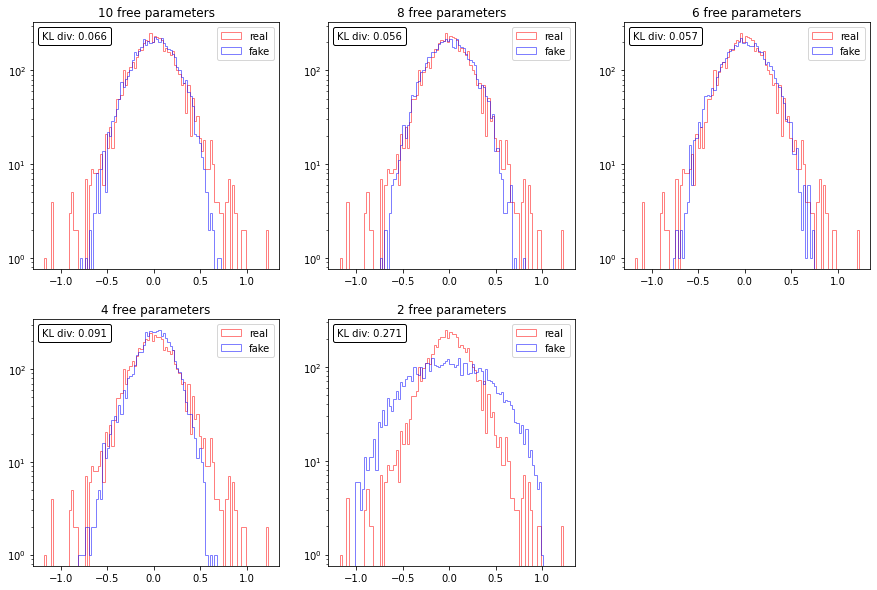

In [10]:
# number of qubits generator
nqubits = 1
# create hamiltonians
def hamiltonian1():
        m0 = hamiltonians.Z(1).matrix
        ham = hamiltonians.Hamiltonian(1, m0)
        return ham
hamiltonian1 = hamiltonian1()
fixed_params = range(0,10,2)
latent_dim=3
samples=5000
nqubits=1
layers=2
rows=2
cols=3
# create quantum generator
circuit = models.Circuit(nqubits)
for l in range(layers):
    for q in range(nqubits):
        circuit.add(gates.RY(q, 0))
        circuit.add(gates.RZ(q, 0))
for q in range(nqubits):
    circuit.add(gates.RY(q, 0)) 
    
pyplot.figure(figsize=(15, 10))

s=qc.generate_training_real_samples(samples)
x_real, y_real = qc.generate_real_samples(samples, s, 3000)

distributions=[]
kl = []
kl.append("---")
distributions.append(x_real)
for i, val in enumerate(fixed_params):
    params = np.loadtxt(f"iterator/PARAMS_1Dgamma_logistic_1_3_2_10000_128_0.1_fixed_params_{val}_0", delimiter=' ', unpack='true')
    
    params = tf.Variable(params)
    #print(params)
    x_fake, y_fake = qc.generate_fake_samples(params, latent_dim, samples, circuit, nqubits, layers, hamiltonian1,val)
    distributions.append(x_fake)
    #x_fake,_= qc2.generate_fake_samples(params, latent_dim, samples)
    #s=qc.generate_training_real_samples(samples)
    #x_real, y_real = qc.generate_real_samples(samples, s, 3000)

    nbins=100
    pyplot.subplot(rows,cols,i+1)
    #pyplot.figure(figsize=(14, 7))
    bins_real=pyplot.hist(x_real, color='red', bins=nbins,histtype='step',label='real', alpha=0.5)
    bins_fake=pyplot.hist(x_fake.numpy(), bins=bins_real[1],histtype='step',color='blue', label='fake', alpha=0.5)
    ax=pyplot.gca()
    kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
    at = AnchoredText(
    f"KL div: {'%.3f' %kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1)}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    #pyplot.text( 0.,0.,"prova", bbox=dict(facecolor='red', alpha=0.5))
    #pyplot.xlim(-1,1)
    pyplot.yscale('log')
    pyplot.title(f'{10-val} free parameters')
    pyplot.legend()
pyplot.show()

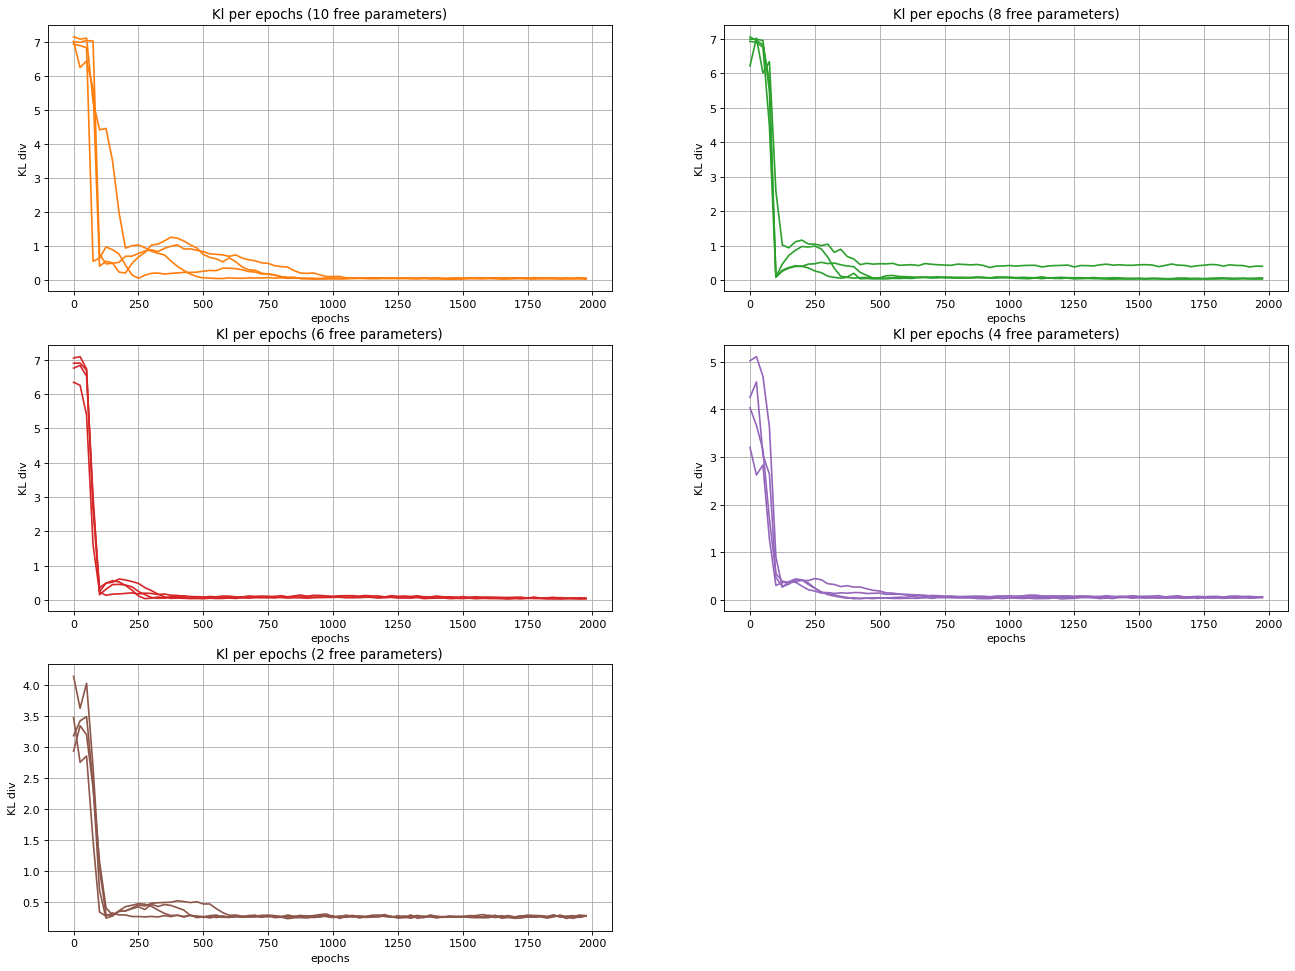

In [13]:
epochs=range(0,2000,25)
pyplot.figure(figsize=(20, 15), dpi=80)
rows=3
cols=2
pyplot.subplot(rows,cols,1)
'''
for i in range (4):
    kl=np.loadtxt(f"iterator/KLdiv_1Dgamma_logistic_1_3_2_10000_128_0.1_4_{i}")
    
    pyplot.plot(epochs[:len(kl)],kl,label=f"simple learning",color="C0")
    pyplot.title(f'Kl per epochs simple learning')
    pyplot.xlabel('epochs')
    pyplot.ylabel('KL div')
    #pyplot.legend()
    pyplot.grid(True)
'''
fixed_params = range(0,10,2)

for i, val in enumerate(fixed_params):
    pyplot.subplot(rows,cols,i+1)
    for j in range (4):
        kl=np.loadtxt(f"iterator/KLdiv_1Dgamma_logistic_1_3_2_10000_128_0.1_{val}_{j}")
        
        pyplot.plot(epochs,kl,color=f"C{i+1}")
    
    pyplot.title(f'Kl per epochs ({10-val} free parameters)')
    pyplot.xlabel('epochs')
    pyplot.ylabel('KL div')
    #pyplot.legend()
    pyplot.grid()

pyplot.show()

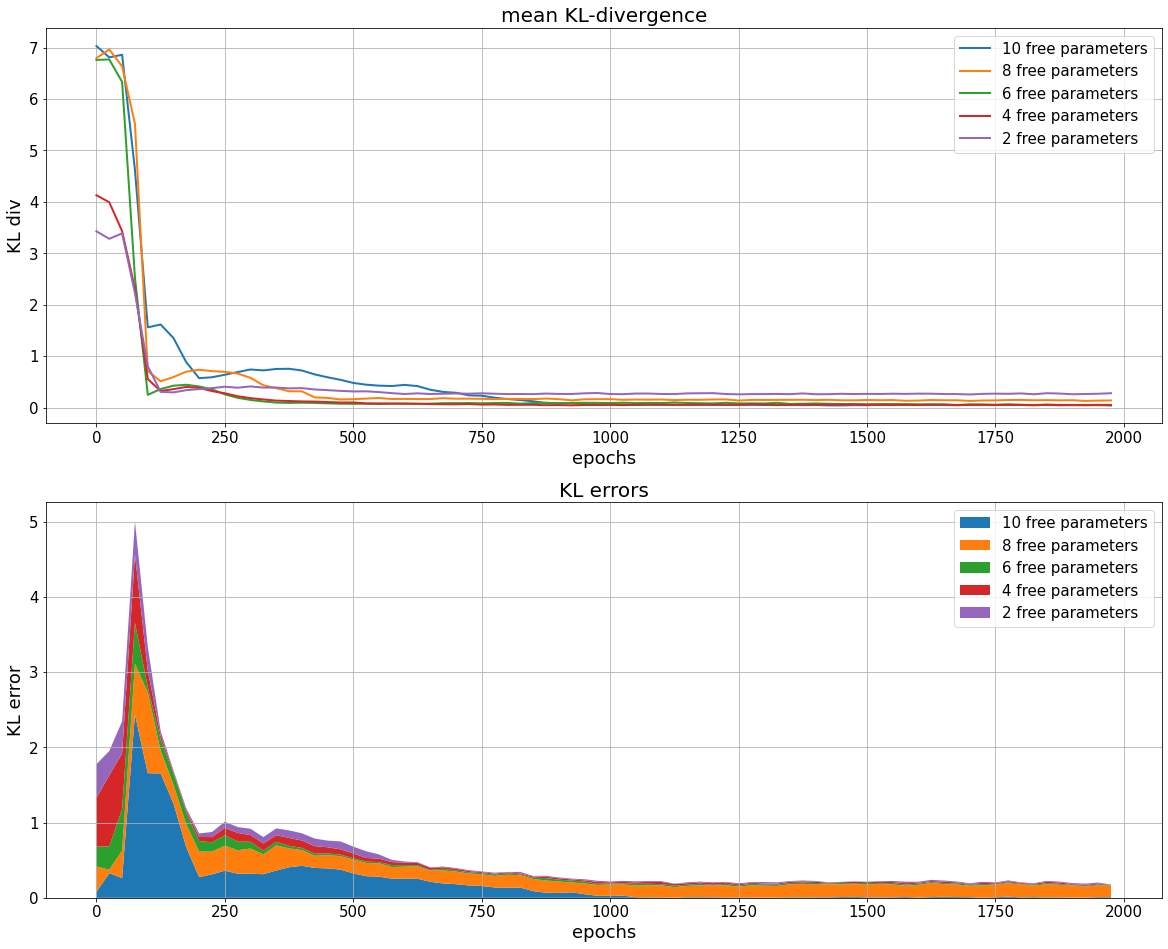

In [35]:
errors=[]
fixed_params=range(0,10,2)

plt.figure(figsize=(20,16))
plt.subplot(2,1,1)

#fig, ax = plt.subplots(figsize=(20,7))
kl_mean = ["---"]
kl_error = ["---"]
kl_data=[[] for i in range(len(fixed_params))]


for i, val in enumerate(fixed_params):
    
    kl_transfer_learning=[]
    for j in range (4):
        kl=np.loadtxt(f"iterator/KLdiv_1Dgamma_logistic_1_3_2_10000_128_0.1_{val}_{j}")
        kl_data[i].append(kl[-1])
        
        kl_transfer_learning.append(kl)
        
    mean=np.mean(kl_transfer_learning, axis=0)
    
    error=np.std(kl_transfer_learning, axis=0)
    errors.append(error)
    kl_mean.append(mean[len(mean)-1])
    kl_error.append(error[len(mean)-1])
    pyplot.plot(epochs,mean,color=f"C{i}",label=f'{10-val} free parameters',linewidth=2,alpha=1)


pyplot.title(f'mean KL-divergence', fontsize=20)
    
pyplot.xlabel('epochs', fontsize=18)
pyplot.ylabel('KL div',fontsize=18)
pyplot.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
pyplot.grid()

# plot errors of KL 

plt.subplot(2,1,2)

labels=[f'{10-val} free parameters' for val in fixed_params]

ax = plt.gca()   
ax.stackplot(epochs, errors,labels=labels)
pyplot.legend(fontsize=15)
pyplot.title("KL errors",fontsize=20)
pyplot.xlabel("epochs",fontsize=18)
pyplot.ylabel("KL error",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
pyplot.grid()
pyplot.show()
plt.show()

In [124]:
print(kl_mean,kl_error)

['---', 0.044943016516000606, 0.13996640103560537, 0.04833595304288341, 0.05376601457102817, 0.2813681549876837] ['---', 0.008245284722414675, 0.15332657992384366, 0.0048849010840707405, 0.0059354098655797554, 0.0030844148387827153]


In [125]:
time_mean=["---"]
time_error=["---"]
t=[[] for i in range (len(fixed_params))]
for i,val in enumerate(fixed_params):
    
    for j in range(4):
        t[i].append(np.loadtxt(f"iterator/1/time_1Dgamma_1_3_2_10000_128_0.1_fixed_params_{val}_{j}"))
    
    time_mean.append(int(np.mean(t[i] )))
    
    time_error.append(int(stats.moment(t[i],moment=2)**(1/2)))
    


In [127]:
x=[]
y=[]
for i,val in enumerate(t):
    
    for j in range(len(val)):
        x.append(10-2*i)
        y.append(int(val[j]))
        
x1=[]
y1=[]
for i,val in enumerate(kl_data):
   
    for j in range(len(val)):
        x1.append(10-2*i)
        y1.append(float(val[j]))


In [128]:
from IPython.display import display
# fake 10 = fake distribution with 10 free parameters
moments = pd.DataFrame(
    {
        "distribution":["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[np.mean(i) for i in distributions],
        "2 moment":[stats.moment(i,moment=2)[0] for i in distributions],
        "3 moment":[stats.moment(i,moment=3)[0] for i in distributions],
        "4 moment":[stats.moment(i,moment=4)[0] for i in distributions],
        "kl mean": [*kl_mean],
        "kl error": [*kl_error],
        "time mean (s)":[*time_mean],
        "time error (s)":[*time_error],
    }
)
display(moments)

,distribution,mean,2 moment,3 moment,4 moment,kl mean,kl error,time mean (s),time error (s)
0,real,0.017932,0.060506,0.001556,0.015493,---,---,---,---
1,fake 10,0.002185,0.047284,-0.000570,0.006133,0.044943,0.008245,8071,1205
2,fake 8,0.004979,0.053608,0.000075,0.007988,0.139966,0.153327,7473,1092
3,fake 6,-0.003551,0.054243,-0.000643,0.008110,0.048336,0.004885,6595,312
4,fake 4,0.004190,0.039155,-0.002629,0.005469,0.053766,0.005935,5899,213
5,fake 2,0.000891,0.153309,0.001547,0.056969,0.281368,0.003084,5146,252


Text(0, 0.5, 'kl')

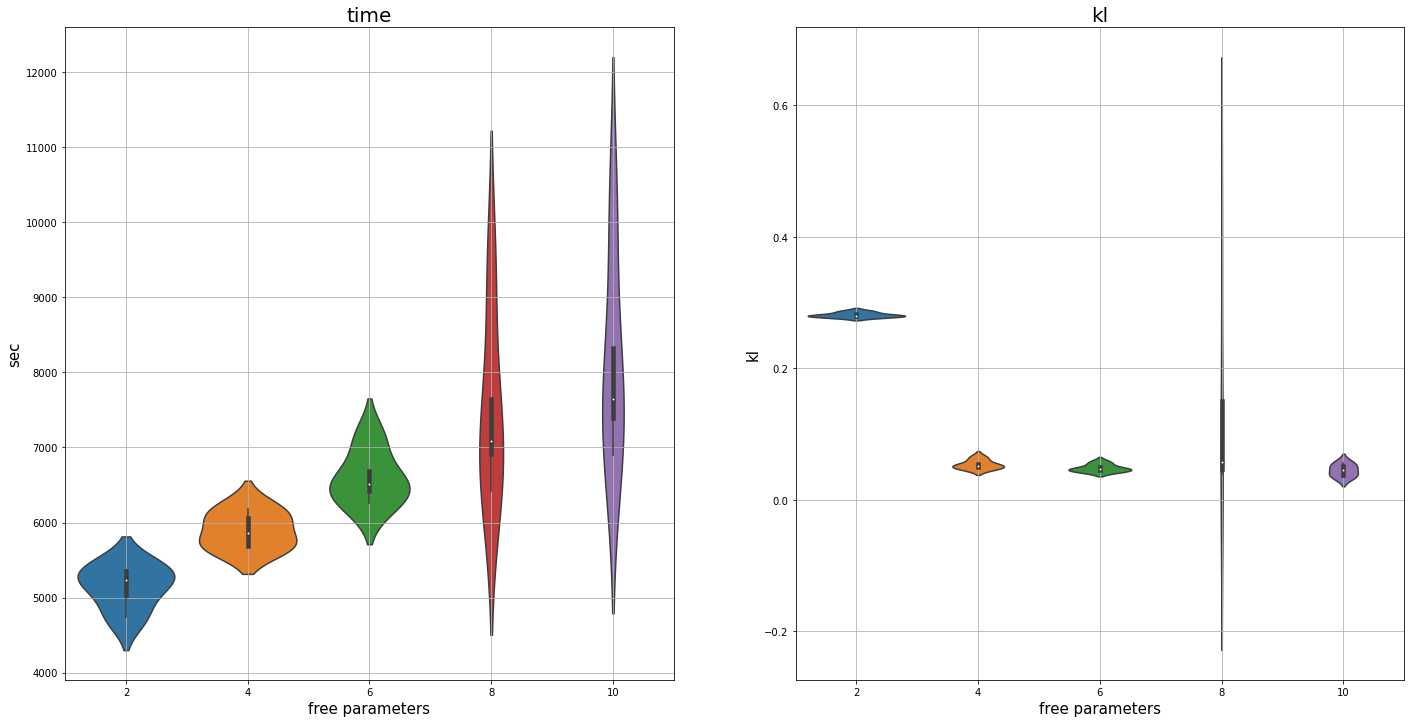

In [140]:
fig, ax = plt.subplots(1,2, figsize = (24, 12))
sns.violinplot(x=x, y=y,ax=ax[0])
ax[0].grid()
ax[0].set_title("time",fontsize = 20)
ax[0].set_xlabel("free parameters",fontsize = 15)
ax[0].set_ylabel("sec",fontsize = 15)

sns.violinplot(x=x1, y=y1,ax=ax[1])
ax[1].grid()
ax[1].set_title("kl",fontsize = 20)
ax[1].set_xlabel("free parameters",fontsize = 15)
ax[1].set_ylabel("kl",fontsize = 15)

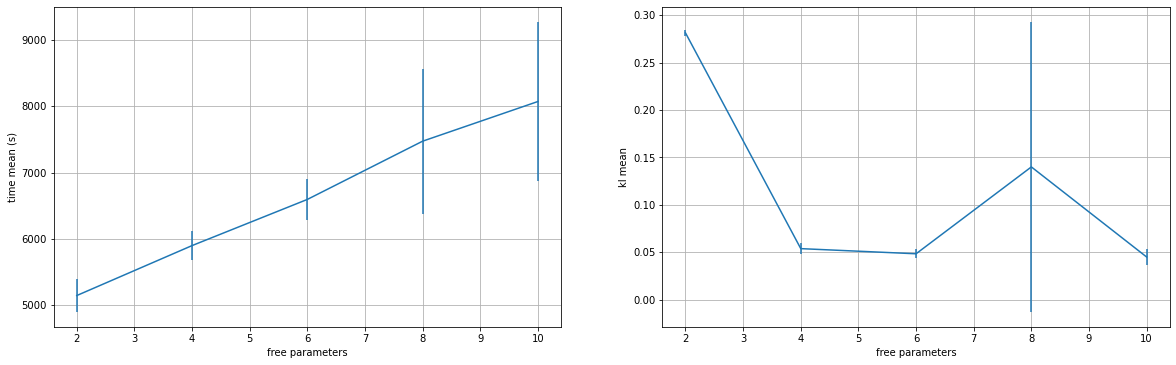

In [64]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
free_params=range(10,0,-2)
plt.errorbar(free_params,moments["time mean (s)"][1:],yerr=moments["time error (s)"][1:])
plt.xlabel("free parameters")
plt.ylabel("time mean (s)")
plt.grid(True)

plt.subplot(3,2,2)
free_params=range(10,0,-2)
plt.errorbar(free_params,moments["kl mean"][1:],yerr=moments["kl error"][1:])
plt.xlabel("free parameters")
plt.ylabel("kl mean")
plt.grid(True)

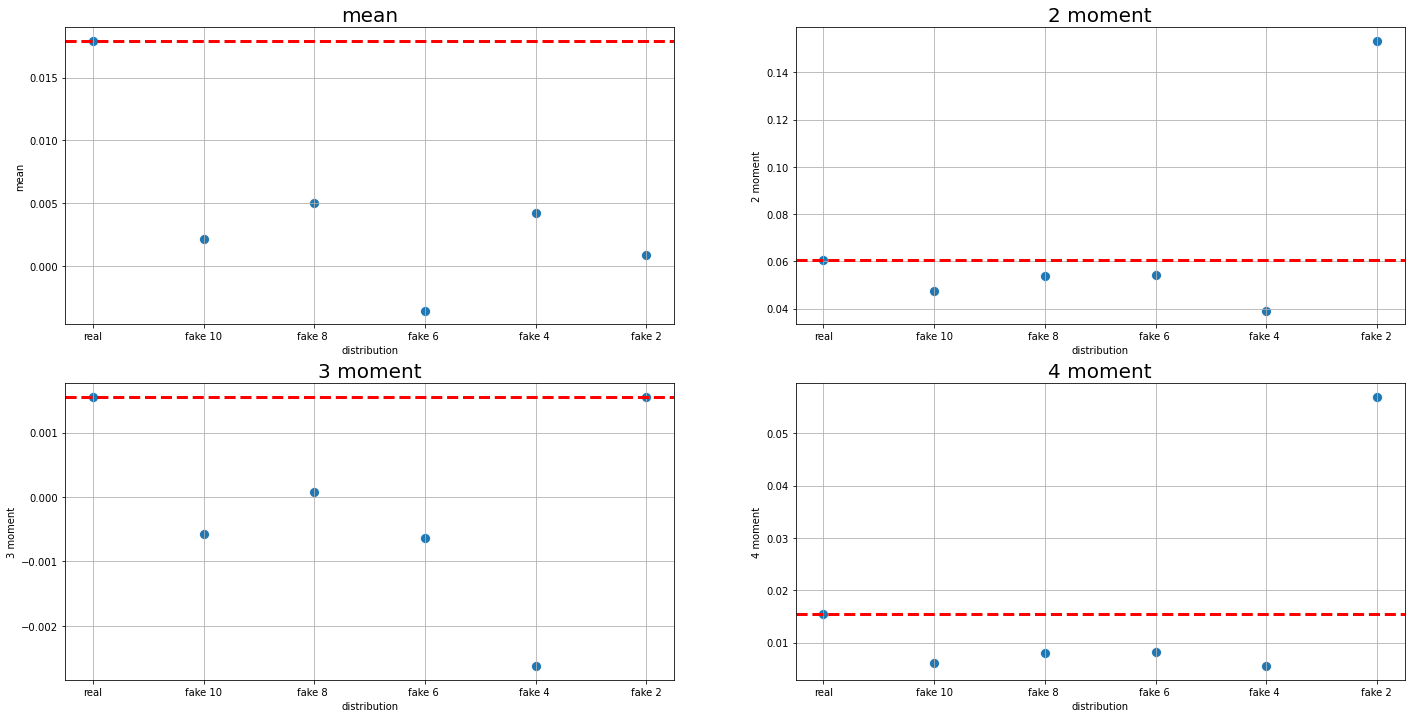

In [51]:

fig, ax = plt.subplots(2,2, figsize = (24, 12))
sns.scatterplot(x="distribution", y="mean", ax=ax[0][0], data = moments, s=100)
ax[0][0].grid()
ax[0][0].axhline(y=moments["mean"][0],ls='--', linewidth=3, color='red') 
ax[0][0].set_title("mean",fontsize = 20)

sns.scatterplot(x="distribution", y="2 moment",ax=ax[0][1], data = moments,s=100)
ax[0][1].axhline(y=moments["2 moment"][0],ls='--', linewidth=3, color='red') 
ax[0][1].set_title("2 moment", fontsize = 20)
ax[0][1].grid()

sns.scatterplot(x="distribution", y="3 moment",ax=ax[1][0], data = moments,s=100)
ax[1][0].axhline(y=moments["3 moment"][0],ls='--', linewidth=3, color='red') 
ax[1][0].set_title("3 moment", fontsize = 20);
ax[1][0].grid()

sns.scatterplot(x="distribution", y="4 moment",ax=ax[1][1], data = moments,s=100)
ax[1][1].axhline(y=moments["4 moment"][0],ls='--', linewidth=3, color='red') 
ax[1][1].set_title("4 moment", fontsize = 20)
ax[1][1].grid()

In [141]:
print(moments.to_latex(index=False))  

\begin{tabular}{lrrrrllll}
\toprule
distribution &      mean &  2 moment &  3 moment &  4 moment &   kl mean &  kl error & time mean (s) & time error (s) \\
\midrule
        real &  0.017932 &  0.060506 &  0.001556 &  0.015493 &       --- &       --- &           --- &            --- \\
     fake 10 &  0.002185 &  0.047284 & -0.000570 &  0.006133 &  0.044943 &  0.008245 &          8071 &           1205 \\
     fake 8  &  0.004979 &  0.053608 &  0.000075 &  0.007988 &  0.139966 &  0.153327 &          7473 &           1092 \\
     fake 6  & -0.003551 &  0.054243 & -0.000643 &  0.008110 &  0.048336 &  0.004885 &          6595 &            312 \\
     fake 4  &  0.004190 &  0.039155 & -0.002629 &  0.005469 &  0.053766 &  0.005935 &          5899 &            213 \\
      fake 2 &  0.000891 &  0.153309 &  0.001547 &  0.056969 &  0.281368 &  0.003084 &          5146 &            252 \\
\bottomrule
\end{tabular}



/var/folders/s2/82sd15fd5zx5zvjy5hnfkg1m0000gn/T/ipykernel_17646/1208205541.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(moments.to_latex(index=False))


confrontare con i simple learning 

In [247]:
# load simple learning distributions (10 params is not considered )

simple_distr = []
for i in range(8,0,-2):
    simple_distr.append(np.loadtxt(f"fake_data_{i}.dat"))

# calculate KL
simple_kl = []

for i,val in enumerate(simple_distr):
    
    
    #bins_real=np.histogram(distributions[i+2], bins=nbins)
    bins_real=np.histogram(x_real, bins=nbins)
    bins_fake=np.histogram(val, bins=bins_real[1])
    
    simple_kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))

# load times
simple_t = []

for i in range(8,0,-2):
    simple_t.append(int(np.loadtxt(f"time_{i}.dat")))
    
print(simple_kl)  
print(simple_t)

[0.07545916551020755, 0.08545946078057659, 6.193039170627008, 0.06180746390521919]
[8533, 7726, 6719, 8289]


In [197]:
simple_data = pd.DataFrame(
    {
        "distribution":["fake 8 ", "fake 6 ", "fake 4 ","fake 2" ],
        "mean":[np.mean(i) for i in simple_distr ],
        "2 moment":[stats.moment(i.tolist(),moment=2) for i in simple_distr],
        "3 moment":[stats.moment(i.tolist(),moment=3) for i in simple_distr],
        "4 moment":[stats.moment(i.tolist(),moment=4) for i in simple_distr],
        "kl": [*simple_kl],
        "time (s)":[*simple_t]
    }
)
display(simple_data)

,distribution,mean,2 moment,3 moment,4 moment,kl,time (s)
0,fake 8,0.010378,0.046280,0.000324,0.006005,0.075459,8533
1,fake 6,-0.003972,0.060712,0.000147,0.010206,0.085459,7726
2,fake 4,-0.624205,0.000000,0.000000,0.000000,6.193039,6719
3,fake 2,0.001666,0.057007,-0.000243,0.008987,0.061807,8289


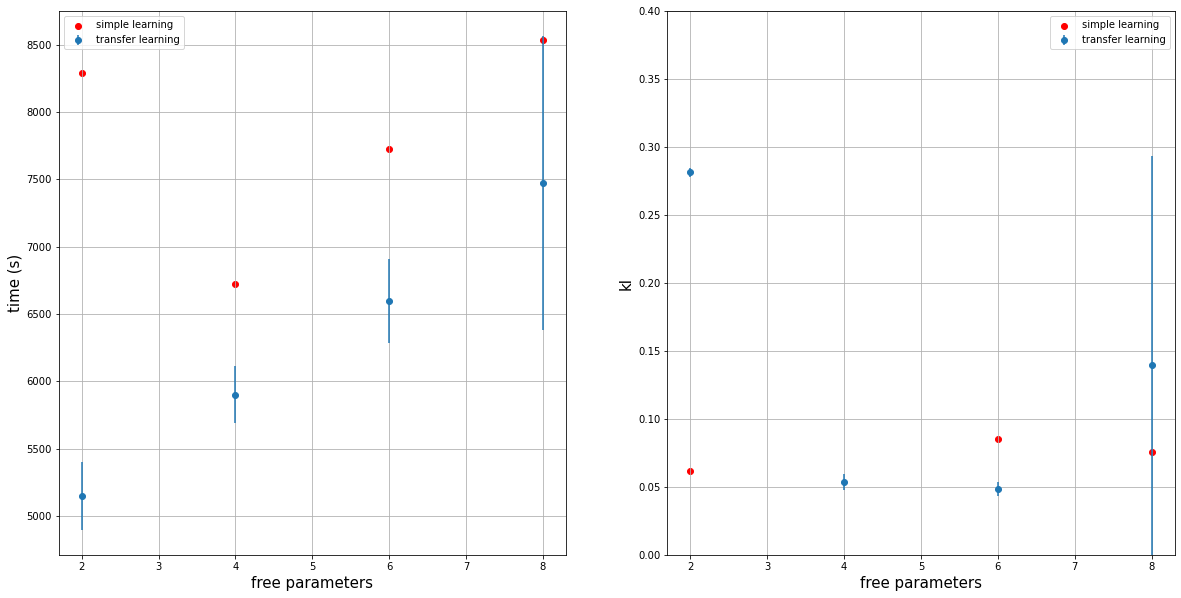

In [224]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
free_params=range(8,0,-2)
plt.errorbar(free_params,moments["time mean (s)"][2:],yerr=moments["time error (s)"][2:],fmt="o",label="transfer learning")
plt.scatter(free_params,simple_data["time (s)"],color="r",label="simple learning")
plt.xlabel("free parameters",fontsize = 15)
plt.ylabel("time (s)",fontsize = 15)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)

plt.errorbar(free_params,moments["kl mean"][2:],yerr=moments["kl error"][2:],fmt="o",label="transfer learning")
plt.scatter(free_params,simple_data["kl"],c="r",label="simple learning")
plt.xlabel("free parameters",fontsize = 15)
plt.ylim((0,0.4))
plt.ylabel("kl",fontsize = 15)
plt.legend()
plt.grid(True)

the kl div of simple learning with 4 free parameters is to large 

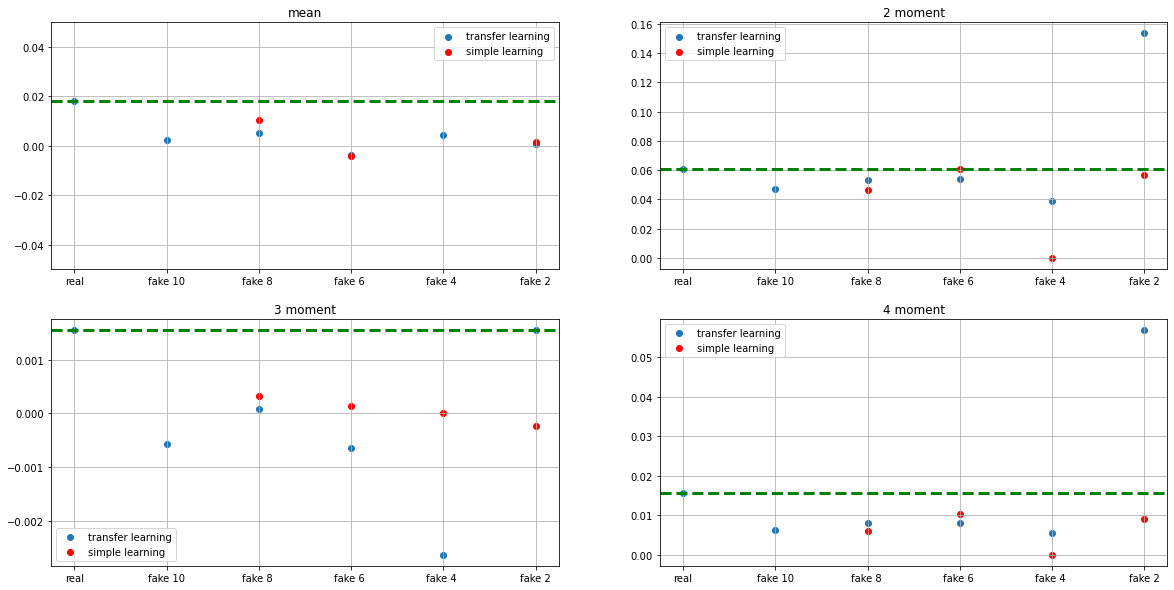

In [242]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
x=["real","fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ]
plt.scatter(x,moments["mean"],label="transfer learning")
plt.scatter(x[2:],simple_data["mean"],color="r",label="simple learning")
plt.axhline(y=moments["mean"][0],ls='--', linewidth=3, color='g') 
plt.title("mean")
plt.ylim((-0.05,0.05))
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.scatter(x,moments["2 moment"],label="transfer learning")
plt.scatter(x[2:],simple_data["2 moment"],color="r",label="simple learning")
plt.axhline(y=moments["2 moment"][0],ls='--', linewidth=3, color='g') 
plt.title("2 moment")
#plt.ylim((-0.05,0.05))
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.scatter(x,moments["3 moment"],label="transfer learning")
plt.scatter(x[2:],simple_data["3 moment"],color="r",label="simple learning")
plt.axhline(y=moments["3 moment"][0],ls='--', linewidth=3, color='g') 
plt.title("3 moment")
#plt.ylim((-0.05,0.05))
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.scatter(x,moments["4 moment"],label="transfer learning")
plt.scatter(x[2:],simple_data["4 moment"],color="r",label="simple learning")
plt.axhline(y=moments["4 moment"][0],ls='--', linewidth=3, color='g') 
plt.title("4 moment")
#plt.ylim((-0.05,0.05))
plt.legend()
plt.grid(True)

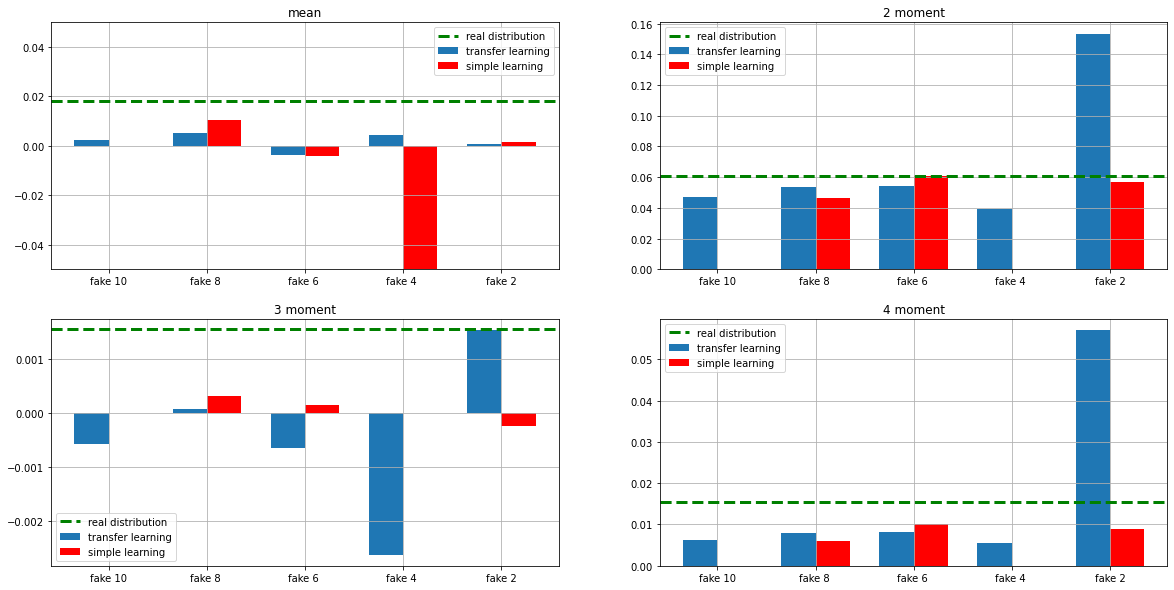

In [266]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
labels=["fake 10","fake 8 ", "fake 6 ", "fake 4 ","fake 2" ]
x = np.arange(len(labels))  # the label locations
width = 0.35 
plt.bar(x - width/2,moments["mean"][1:],width,label="transfer learning")
plt.bar(x[1:] + width/2,simple_data["mean"],width,color="r",label="simple learning")
plt.axhline(y=moments["mean"][0],ls='--', linewidth=3, color='g',label="real distribution") 
plt.title("mean")
plt.ylim((-0.05,0.05))
plt.legend()
ax=plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.grid(True)

plt.subplot(2,2,2)
plt.bar(x - width/2,moments["2 moment"][1:],width,label="transfer learning")
plt.bar(x[1:] + width/2,simple_data["2 moment"],width,color="r",label="simple learning")
plt.axhline(y=moments["2 moment"][0],ls='--', linewidth=3, color='g',label="real distribution") 
plt.title("2 moment")
ax=plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend()
plt.grid(True)


plt.subplot(2,2,3)
plt.bar(x - width/2,moments["3 moment"][1:],width,label="transfer learning")
plt.bar(x[1:] + width/2,simple_data["3 moment"],width,color="r",label="simple learning")
plt.axhline(y=moments["3 moment"][0],ls='--', linewidth=3, color='g',label="real distribution") 
plt.title("3 moment")
ax=plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.bar(x - width/2,moments["4 moment"][1:],width,label="transfer learning")
plt.bar(x[1:] + width/2,simple_data["4 moment"],width,color="r",label="simple learning")
plt.axhline(y=moments["4 moment"][0],ls='--', linewidth=3, color='g',label="real distribution") 
plt.title("4 moment")
ax=plt.gca()
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend()
plt.grid(True)

in fake 4 dove manca barra rossa vuol dire che è zero

[0.030287207047502845, 0.024027461353548076, 5.948564035678965, 0.4704336135365349]


Text(0.5, 0, 'free parameters')

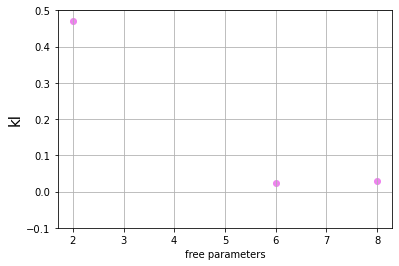

In [254]:
# kl div between transfer and simple learning distributions
match_kl = []
for i,val in enumerate(simple_distr):
    
    
    bins_real=np.histogram(distributions[i+2], bins=nbins)
    bins_fake=np.histogram(val, bins=bins_real[1])
    
    match_kl.append(kl_divergence(bins_real[0],bins_fake[0],epsilon=0.1))
print(match_kl)
x=range(8,0,-2)
plt.scatter(x,match_kl,color="violet")
plt.grid(True)
plt.ylim((-0.1,0.5))
plt.ylabel("kl",fontsize=15)
plt.xlabel("free parameters")

fare una tabella anzichè grafico